In [235]:
import gymnasium as gym
import customENV.customENVInit
import numpy as np
import matplotlib.pyplot as plt

In [236]:
# Create a Combine-v1 environment
env = gym.make("Combine-v1")

# Reset the environment
obs, info = env.reset()

# Get the observation space
low = env.observation_space.low
high = env.observation_space.high

# Set the discritization
disc = 500

# Create a list of 10 states per dimension between low and high
x = np.linspace(low[0], high[0], disc)
y = np.linspace(low[1], high[1], disc)

# Create a list of rewards
rewards = []

# Create a list of reach
reach = []

# Create a list of avoid
avoid = []

# Iterate over x,y states
for i in x:
    for j in y:
        
        # Create a state
        state = np.array([i, j, 0, 0, 0])

        # Reset the environment to the state
        obs, info = env.reset(state_init =state)
        
        # Step the environment with 0 action
        obs, reward, done, term, info = env.step([0,0,0])

        # Append the reward to the list
        rewards.append([reward,i,j])

        # Append the reach to the list
        reach.append([info["reach"],i,j])

        # Append the avoid to the list
        avoid.append([info["avoid"],i,j])

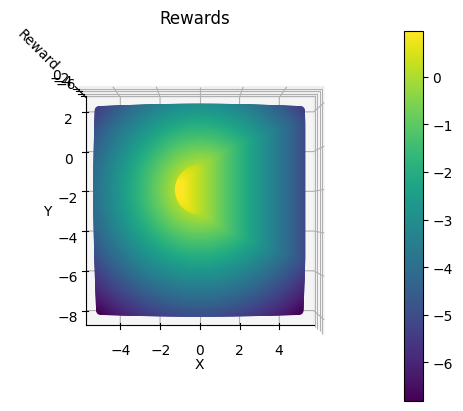

In [240]:
# Create a 3d scatter plot of the rewards
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.colorbar(ax.scatter([x[1] for x in rewards], [y[2] for y in rewards], [x[0] for x in rewards], c=[x[0] for x in rewards]))
# Switch to a top view
ax.view_init(90, 90, 180)
# Set the labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Reward')
plt.title("Rewards")
plt.show()

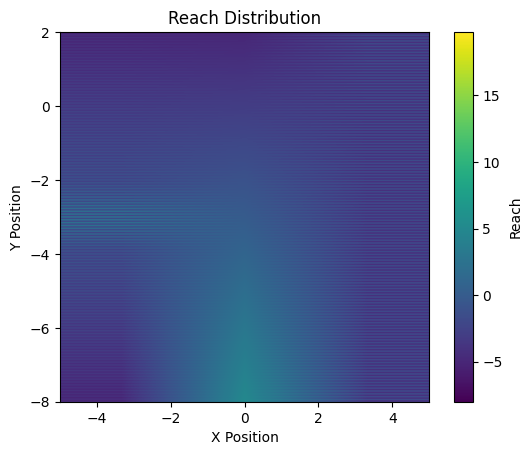

In [238]:
# Create a 2d plot of reach scaled to within x,y space
plt.figure()
plt.imshow(reach, extent=[low[0], high[0], low[1], high[1]], interpolation='bilinear')
plt.colorbar(label='Reach')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Reach Distribution')
plt.show()

TypeError: Length of x (500) must match number of columns in z (3)

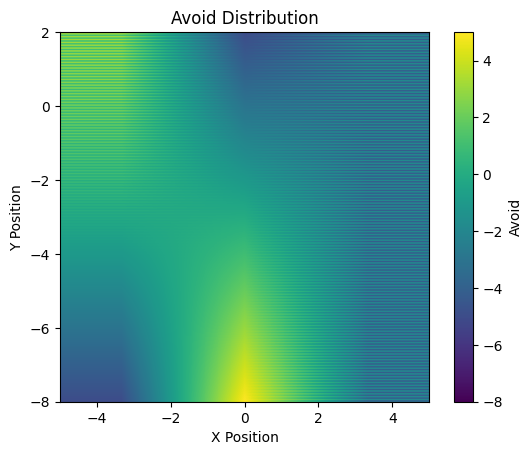

In [239]:
# Create a 2d plot of avoid scaled to within x,y space
plt.figure()
plt.imshow(avoid, extent=[low[0], high[0], low[1], high[1]], interpolation='bilinear')
plt.colorbar(label='Avoid')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Avoid Distribution')
# Create a level set line at 0
plt.contour(x, y, avoid, levels=[-2,-1,0])
plt.show()

In [234]:
# Print the maximum reward
print("Maximum reward:", np.max(rewards[0]))

# Print the minimum reward
print("Minimum reward:", np.min(rewards[0]))

Maximum reward: -5.0
Minimum reward: -8.0


In [200]:
# Test the center of the target

# Reset the environment to x=0, y=-2
env.reset(state_init = np.array([0, -2, 0, 0, 0]))

# Step the environment with 0 action
obs, reward = env.step([0,0,0])[0:2]

# Print the reward
print("Reward at x=0, y=-2:", reward)

Reward at x=0, y=-2: 0
